# Capstone: Web Traffic Time Series Forecasting

![web](images/map_webtraffic.png)

reference: [Kaggle Challenge 2017](https://www.kaggle.com/competitions/web-traffic-time-series-forecasting/data)

- Web traffic can be defined as the number of visits to a website, including requests sent and received by web users. We aim to predict future web traffic for approximately a total of 145k Wikipedia articles to make better traffic control decisions. The increase in traffic for the websites could cause a lot of inconvenience for the users by a crashed site or very slow loading time. Therefore, a traffic management technique or plan should be put in place to reduce the risk of such problems.

# Import packages and define functions

In [69]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm # to show Japanese & Chinese character
import re
import seaborn as sns
import datetime 
from collections import Counter

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA

from prophet import Prophet

from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.preprocessing.sequence import TimeseriesGenerator

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 

sns.set_style('ticks', rc={'xtick.direction':'in', 'ytick.direction':'in', \
                           'xtick.top':True, 'ytick.right':True})

# Data Load

In [3]:
datadir = '../datasets/raw'
datadir_pr = '../datasets/processed'  # directory where the cleaned datasets are stored

## Datasets consist of train and key:
- **train.csv**
    - 145k rows each of wich represent a different Wikipedia page
    - 804 columns: article + daily traffic on that particular Wikipedia page (803 days: 2015-07-01 to 2017-09-10)
    - The first column contains the name of the page which includes 
        - the language of the page (e.g., English en, Spanish es, Chinese zh)
        - type of access (e.g., desktop, all access)
        - agent (e.g., spider, actual traffic)
- **key.csv**
    - the mapping between the page names and the shortened Id column used for prediction
    - 2 columns: page name (consistent to the page name in train.csv) and id

In [23]:
''' Read the training dataset '''
train = pd.read_csv(os.path.join(datadir_pr, 'train_imputed.csv.zip'))
#key   = pd.read_csv(os.path.join(datadir, 'key_2.csv.zip'))

In [54]:
train.head()

,Page,2015-07-01 00:00:00,2015-07-02 00:00:00,2015-07-03 00:00:00,2015-07-04 00:00:00,2015-07-05 00:00:00,2015-07-06 00:00:00,2015-07-07 00:00:00,2015-07-08 00:00:00,2015-07-09 00:00:00,...,2017-09-04 00:00:00,2017-09-05 00:00:00,2017-09-06 00:00:00,2017-09-07 00:00:00,2017-09-08 00:00:00,2017-09-09 00:00:00,2017-09-10 00:00:00,Language,Agent,Access
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,18.0,16.0,27.0,29.0,23.0,54.0,38.0,Chinese,spider,all-access
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,19.0,54.0,25.0,26.0,23.0,13.0,81.0,Chinese,spider,all-access
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,2.0,4.0,7.0,3.0,4.0,7.0,6.0,Chinese,spider,all-access
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,9.0,6.0,16.0,19.0,30.0,38.0,4.0,Chinese,spider,all-access
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,20.0,23.0,28.0,14.0,8.0,7.0,Chinese,spider,all-access


In [78]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 807 entries, Page to 2017-09-10 00:00:00
dtypes: float64(803), object(4)
memory usage: 893.1+ MB


In [62]:
''' re-order the column: 
    currently Language, Agent, Access columns are located at the end of column
    -> pull into right after Page columns
    '''

cols = train.columns.tolist()
cols = [cols[0]] + cols[-3:] + cols[1:-3]
train = train.loc[:,cols]

In [67]:
train.sample(5)

,Page,Language,Agent,Access,2015-07-01 00:00:00,2015-07-02 00:00:00,2015-07-03 00:00:00,2015-07-04 00:00:00,2015-07-05 00:00:00,2015-07-06 00:00:00,...,2017-09-01 00:00:00,2017-09-02 00:00:00,2017-09-03 00:00:00,2017-09-04 00:00:00,2017-09-05 00:00:00,2017-09-06 00:00:00,2017-09-07 00:00:00,2017-09-08 00:00:00,2017-09-09 00:00:00,2017-09-10 00:00:00
57112,小林涼子_ja.wikipedia.org_mobile-web_all-agents,Japanese,all-agents,mobile-web,469.0,517.0,669.0,580.0,539.0,369.0,...,439.0,512.0,482.0,388.0,358.0,510.0,410.0,276.0,368.0,372.0
92097,Octubre_es.wikipedia.org_all-access_all-agents,Spanish,all-agents,all-access,286.0,248.0,173.0,178.0,192.0,226.0,...,825.0,563.0,668.0,853.0,946.0,808.0,822.0,603.0,418.0,490.0
89597,ジェイミー夏樹_ja.wikipedia.org_desktop_all-agents,Japanese,all-agents,desktop,0.0,0.0,0.0,0.0,0.0,0.0,...,23.0,30.0,27.0,26.0,36.0,23.0,22.0,38.0,31.0,29.0
17143,"Лавроненко,_Константин_Николаевич_ru.wikipedia...",Russian,all-agents,mobile-web,22.0,36.0,41.0,41.0,42.0,50.0,...,148.0,116.0,146.0,102.0,86.0,117.0,103.0,136.0,150.0,139.0
119103,SERVAMP_-サーヴァンプ-_ja.wikipedia.org_all-access_a...,Japanese,all-agents,all-access,116.0,117.0,114.0,170.0,182.0,162.0,...,285.0,494.0,621.0,411.0,288.0,315.0,302.0,246.0,372.0,422.0


# Feature Engineering

In [91]:
''' wide format to long format by using pandas.melt '''

#train_flattened = pd.melt(train[list(train.columns[-20:])+['Page','Language','Agent','Access']], id_vars=['Page','Language','Agent','Access'], var_name='date', value_name='Visits')
train_flattened = pd.melt(train, id_vars=['Page','Language','Agent','Access'], var_name='date', value_name='Visits')

In [92]:
''' to datetime format '''
train_flattened.date = pd.to_datetime(train_flattened.date)

In [93]:
train_flattened['weekday'] = train_flattened['date'].apply(lambda x: x.weekday())
train_flattened['weekend'] = ((train_flattened.date.dt.dayofweek) // 5 == 1).astype(float)

train_flattened['year']=train_flattened.date.dt.year 
train_flattened['month']=train_flattened.date.dt.month 
train_flattened['day']=train_flattened.date.dt.day

In [94]:
train_flattened

,Page,Language,Agent,Access,date,Visits,weekday,weekend,year,month,day
0,2NE1_zh.wikipedia.org_all-access_spider,Chinese,spider,all-access,2015-07-01,18.0,2,0.0,2015,7,1
1,2PM_zh.wikipedia.org_all-access_spider,Chinese,spider,all-access,2015-07-01,11.0,2,0.0,2015,7,1
2,3C_zh.wikipedia.org_all-access_spider,Chinese,spider,all-access,2015-07-01,1.0,2,0.0,2015,7,1
3,4minute_zh.wikipedia.org_all-access_spider,Chinese,spider,all-access,2015-07-01,35.0,2,0.0,2015,7,1
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,Chinese,spider,all-access,2015-07-01,0.0,2,0.0,2015,7,1
...,...,...,...,...,...,...,...,...,...,...,...
116485584,Underworld_(serie_de_películas)_es.wikipedia.o...,Spanish,spider,all-access,2017-09-10,2.0,6,1.0,2017,9,10
116485585,Resident_Evil:_Capítulo_Final_es.wikipedia.org...,Spanish,spider,all-access,2017-09-10,4.0,6,1.0,2017,9,10
116485586,Enamorándome_de_Ramón_es.wikipedia.org_all-acc...,Spanish,spider,all-access,2017-09-10,6.0,6,1.0,2017,9,10
116485587,Hasta_el_último_hombre_es.wikipedia.org_all-ac...,Spanish,spider,all-access,2017-09-10,3.0,6,1.0,2017,9,10


### restart point by reading restored 'train_flattened' data

In [3]:
train_flattened = pd.read_csv(os.path.join(datadir_pr, 'train_flattened.csv.zip'), parse_dates=['date'])

In [4]:
train_flattened

,Page,Language,Agent,Access,date,Visits,weekday,weekend,year,month,day
0,2NE1_zh.wikipedia.org_all-access_spider,Chinese,spider,all-access,2015-07-01,18.0,2,0.0,2015,7,1
1,2PM_zh.wikipedia.org_all-access_spider,Chinese,spider,all-access,2015-07-01,11.0,2,0.0,2015,7,1
2,3C_zh.wikipedia.org_all-access_spider,Chinese,spider,all-access,2015-07-01,1.0,2,0.0,2015,7,1
3,4minute_zh.wikipedia.org_all-access_spider,Chinese,spider,all-access,2015-07-01,35.0,2,0.0,2015,7,1
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,Chinese,spider,all-access,2015-07-01,0.0,2,0.0,2015,7,1
...,...,...,...,...,...,...,...,...,...,...,...
116485584,Underworld_(serie_de_películas)_es.wikipedia.o...,Spanish,spider,all-access,2017-09-10,2.0,6,1.0,2017,9,10
116485585,Resident_Evil:_Capítulo_Final_es.wikipedia.org...,Spanish,spider,all-access,2017-09-10,4.0,6,1.0,2017,9,10
116485586,Enamorándome_de_Ramón_es.wikipedia.org_all-acc...,Spanish,spider,all-access,2017-09-10,6.0,6,1.0,2017,9,10
116485587,Hasta_el_último_hombre_es.wikipedia.org_all-ac...,Spanish,spider,all-access,2017-09-10,3.0,6,1.0,2017,9,10


## Check weekly averaged total view

In [5]:
week_group = train_flattened[['Page','weekday','Visits']].groupby(['weekday']).mean()

In [6]:
week_group

,Visits
weekday,
0,1360.811280
1,1305.256725
2,1287.498449
3,1255.011104
4,1212.157618
5,1225.888199
6,1326.380835


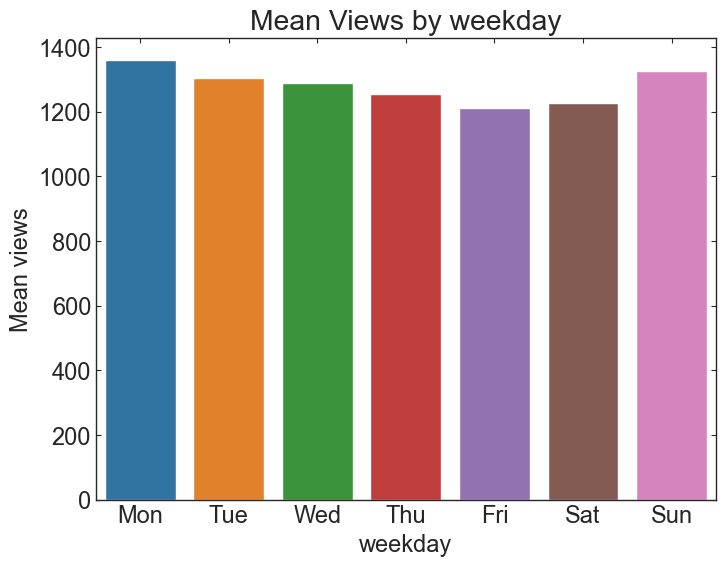

In [7]:
# ytick format function 
# 'B' stands for billion (1e9)
#ticklabel_func = lambda value, tick_number: "{:.0f}B".format(value/1e9)

# xtick format function 
week_name = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
ticklabel_func2 = lambda value, tick_number: week_name[value]

ax = sns.barplot(data=week_group.T)

ax.xaxis.set_major_formatter(plt.FuncFormatter(ticklabel_func2))
#ax.yaxis.set_major_formatter(plt.FuncFormatter(ticklabel_func))
ax.tick_params(axis='x')
ax.set(title='Mean Views by weekday', ylabel='Mean views');

## Check monthly averaged total view

In [8]:
month_group = train_flattened[['month','Visits']].groupby(['month']).mean()

In [9]:
month_group

,Visits
month,
1,1478.257373
2,1442.406120
3,1284.650886
4,1261.892368
5,1225.984335
6,1171.003058
7,1186.623835
8,1252.392473
9,1235.659223


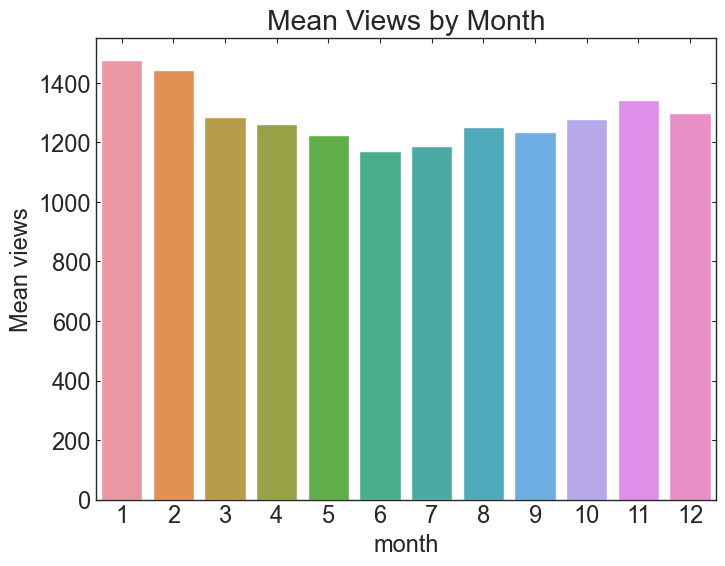

In [10]:
# ytick format function 
# 'B' stands for billion (1e9)
#ticklabel_func = lambda value, tick_number: "{:.0f}B".format(value/1e9)

ax = sns.barplot(data=month_group.T)

#ax.yaxis.set_major_formatter(plt.FuncFormatter(ticklabel_func))
ax.tick_params(axis='x')
ax.set(title='Mean Views by Month', ylabel='Mean views');

## Check yearly averaged total view

In [11]:
year_group = train_flattened[['year','Visits']].groupby(['year']).mean()

In [12]:
year_group

,Visits
year,
2015,1119.775017
2016,1408.650106
2017,1215.908594


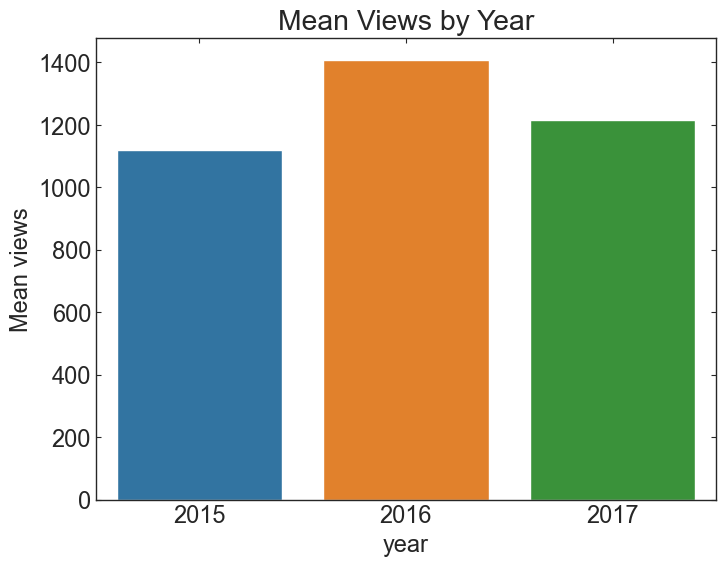

In [13]:
# ytick format function 
# 'B' stands for billion (1e9)
#ticklabel_func = lambda value, tick_number: "{:.0f}B".format(value/1e9)

ax = sns.barplot(data=year_group.T)

#ax.yaxis.set_major_formatter(plt.FuncFormatter(ticklabel_func))
ax.tick_params(axis='x')
ax.set(title='Mean Views by Year', ylabel='Mean views');

## Check weekend vs. weekdays for total view

In [14]:
weekend_group = train_flattened[['weekend','Visits']].groupby(['weekend']).mean()

In [15]:
weekend_group

,Visits
weekend,
0.0,1283.976400
1.0,1276.134517


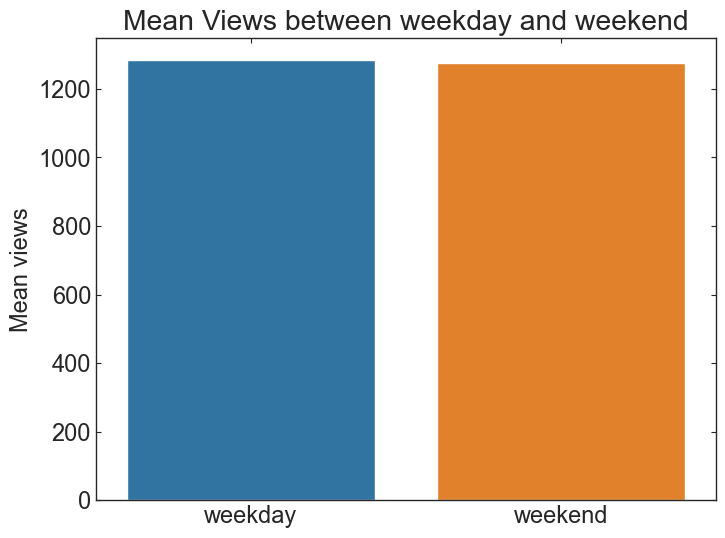

In [16]:
# xtick format function 
weekend_name = {0:'weekday', 1:'weekend'}
ticklabel_func = lambda value, tick_number: weekend_name[value]

ax = sns.barplot(data=weekend_group.T)

ax.xaxis.set_major_formatter(plt.FuncFormatter(ticklabel_func))
ax.tick_params(axis='x')
ax.set(title='Mean Views between weekday and weekend', ylabel='Mean views', xlabel='');

## Prepare the daily averaged total view for ML

In [17]:
mean_timeSeries = train_flattened[['date','weekday','weekend','year','month','day','Visits']].groupby(['date']).mean()

In [18]:
mean_timeSeries

,weekday,weekend,year,month,day,Visits
date,,,,,,
2015-07-01,2.0,0.0,2015.0,7.0,1.0,1024.882127
2015-07-02,3.0,0.0,2015.0,7.0,2.0,1031.251727
2015-07-03,4.0,0.0,2015.0,7.0,3.0,973.138768
2015-07-04,5.0,1.0,2015.0,7.0,4.0,1003.810839
2015-07-05,6.0,1.0,2015.0,7.0,5.0,1044.361908
...,...,...,...,...,...,...
2017-09-06,2.0,0.0,2017.0,9.0,6.0,1192.459890
2017-09-07,3.0,0.0,2017.0,9.0,7.0,1250.224337
2017-09-08,4.0,0.0,2017.0,9.0,8.0,947.043023


In [19]:
mean_timeSeries.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 803 entries, 2015-07-01 to 2017-09-10
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   weekday  803 non-null    float64
 1   weekend  803 non-null    float64
 2   year     803 non-null    float64
 3   month    803 non-null    float64
 4   day      803 non-null    float64
 5   Visits   803 non-null    float64
dtypes: float64(6)
memory usage: 43.9 KB


In [20]:
''' save timeSeries dataset '''
mean_timeSeries.to_csv(os.path.join(datadir_pr, 'mean_timeSeries.csv.zip'), compression='zip')

### restart point by reading restored data

In [4]:
mean_timeSeries = pd.read_csv(os.path.join(datadir_pr, 'mean_timeSeries.csv.zip'), parse_dates=['date'], index_col='date')

In [5]:
mean_timeSeries.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 803 entries, 2015-07-01 to 2017-09-10
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   weekday  803 non-null    float64
 1   weekend  803 non-null    float64
 2   year     803 non-null    float64
 3   month    803 non-null    float64
 4   day      803 non-null    float64
 5   Visits   803 non-null    float64
dtypes: float64(6)
memory usage: 43.9 KB


In [6]:
''' rolling data '''
mean_timeSeries_roll7 = mean_timeSeries['Visits'].rolling(7).mean()
mean_timeSeries_roll7.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 803 entries, 2015-07-01 to 2017-09-10
Series name: Visits
Non-Null Count  Dtype  
--------------  -----  
797 non-null    float64
dtypes: float64(1)
memory usage: 12.5 KB


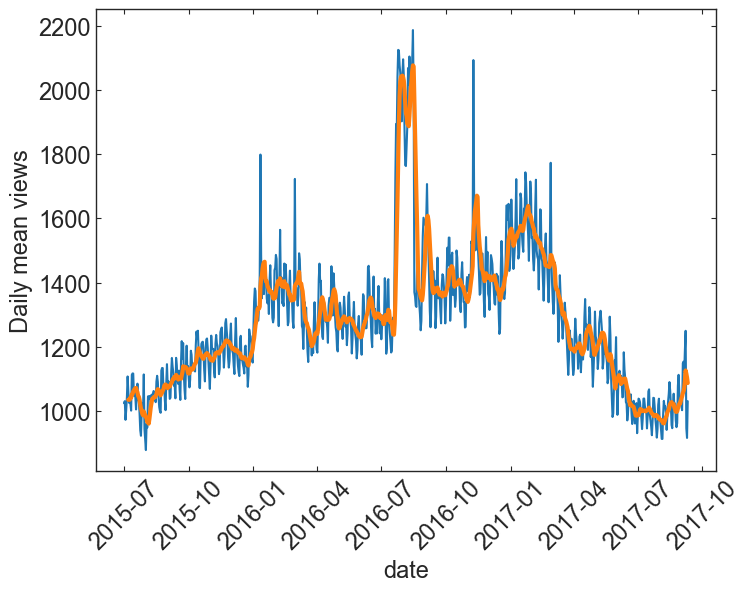

In [7]:
fig, ax = plt.subplots()

ax = sns.lineplot(data=mean_timeSeries, y='Visits', x=mean_timeSeries.index)
sns.lineplot(data=mean_timeSeries_roll7, lw=3, color='C1', ax=ax)
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel('Daily mean views');

# Check the stationarity

In [8]:
decmp = seasonal_decompose(mean_timeSeries.Visits, model='multiplicative')

decmp_seasonal = decmp.seasonal
decmp_trend = decmp.trend
decmp_resid = decmp.resid

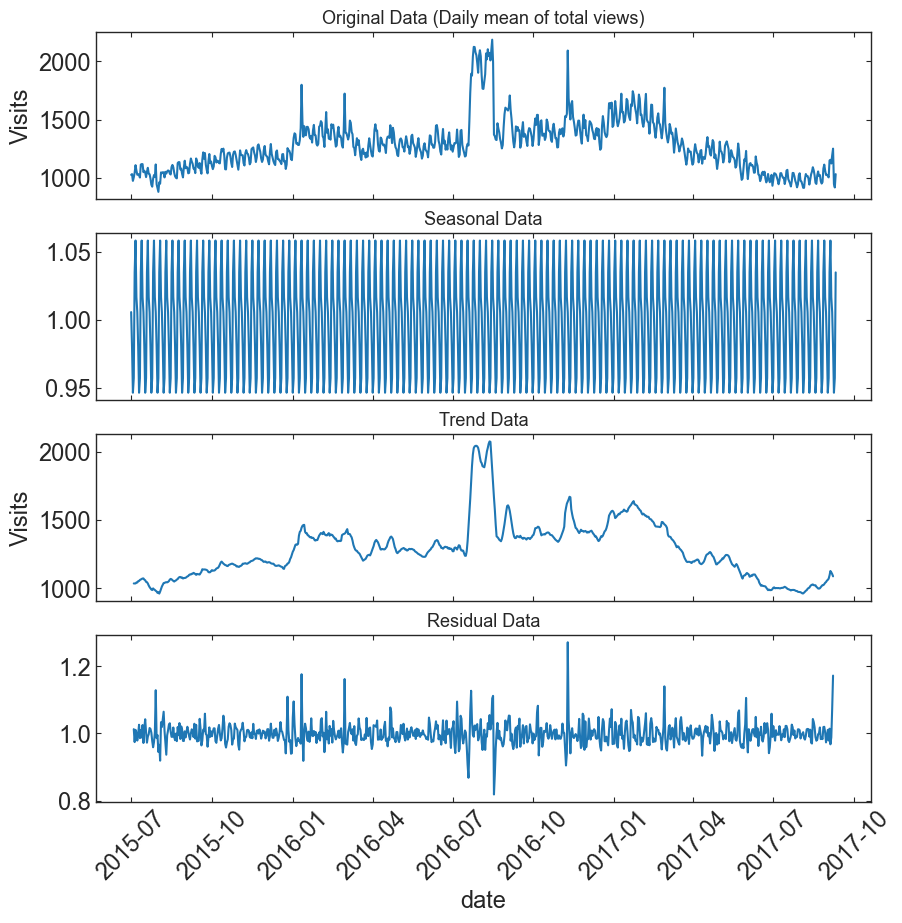

In [9]:
# Plot the original data, the trend, the seasonality, and the residuals 

fig, axes = plt.subplots(4,1, figsize=(10,10), sharex=True)
axf = axes.flat

title_size=13
# original data
sns.lineplot(x=mean_timeSeries.index, y=mean_timeSeries.Visits, ax=axf[0])
axf[0].set_title('Original Data (Daily mean of total views)', size=title_size)
#ticklabel_func = lambda value, tick_number: "{:.1f} K".format(value/1e3) 
#axf[0].yaxis.set_major_formatter(plt.FuncFormatter(ticklabel_func))

# Seasonal data
sns.lineplot(x=mean_timeSeries.index, y=decmp.seasonal, ax=axf[1])
axf[1].set_title('Seasonal Data', size=title_size)
axf[1].set_ylabel('')
#ticklabel_func = lambda value, tick_number: "{:.5f}".format(value) 
#axf[1].yaxis.set_major_formatter(plt.FuncFormatter(ticklabel_func))

# Trend data
sns.lineplot(x=mean_timeSeries.index, y=decmp.trend, ax=axf[2])
axf[2].set_title('Trend Data', size=title_size)
axf[2].set_ylabel('Visits')
#ticklabel_func = lambda value, tick_number: "{:.1f} K".format(value/1e3) 
#axf[2].yaxis.set_major_formatter(plt.FuncFormatter(ticklabel_func))
#axf[2].tick_params(axis='x', rotation=45)

# Residual data
sns.lineplot(x=mean_timeSeries.index, y=decmp.resid, ax=axf[3])
axf[3].set_title('Residual Data', size=title_size)
axf[3].set_ylabel('')
#ticklabel_func = lambda value, tick_number: "{:.5f}".format(value) 
#axf[3].yaxis.set_major_formatter(plt.FuncFormatter(ticklabel_func))
axf[3].tick_params(axis='x', rotation=45)

# adjust spaces
fig.subplots_adjust(hspace=0.2)

In [10]:
def report_stationarity(TS_data):
    ''' conduct Augmented Dickey Fuller test to 
        evaluate the stationarity of the Time series 
    '''
    
    result   = adfuller(TS_data)
    adf      = result[0]
    p_val    = result[1]
    crit_val = result[4]
    print('test statistics: {}'.format(adf))
    print('p-value: {}'.format(p_val))
    print('critical values: {}'.format(crit_val))
    print('-'*100)
    
    if (p_val < 0.05) and (adf < crit_val['5%']):
        print('The series is likely stationary!!')
    else:
        print('The series is NOT likely stationary!!')

In [11]:
# print out the ADF summary
report_stationarity(mean_timeSeries.Visits)

test statistics: -2.6910718741582897
p-value: 0.07559600807637526
critical values: {'1%': -3.438750669890019, '5%': -2.8652477937238703, '10%': -2.56874438754281}
----------------------------------------------------------------------------------------------------
The series is NOT likely stationary!!


## Making the Time Series data Stationary

### Log Transformation

In [12]:
ts_log = mean_timeSeries[['Visits']].copy()
ts_log['Log_Visits'] = np.log(ts_log.Visits)

# print out the ADF summary
report_stationarity(ts_log.Log_Visits)

test statistics: -2.292321199650113
p-value: 0.17445649893813658
critical values: {'1%': -3.438750669890019, '5%': -2.8652477937238703, '10%': -2.56874438754281}
----------------------------------------------------------------------------------------------------
The series is NOT likely stationary!!


### Differencing

In [13]:
''' differencing '''
ts_diff = mean_timeSeries[['Visits']].copy()
ts_diff['Diff_Visits'] = mean_timeSeries.Visits.diff()
#ts_diff.dropna(inplace=True)

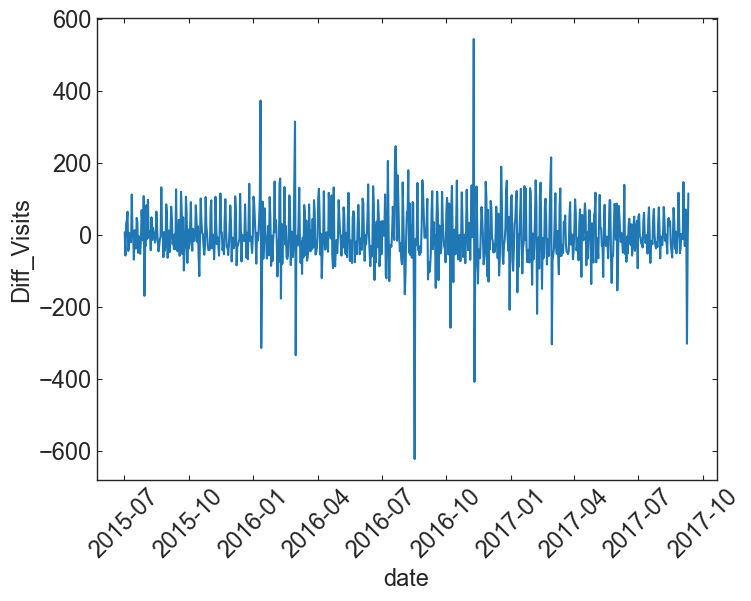

In [14]:
fig, ax = plt.subplots()

sns.lineplot(y=ts_diff.Diff_Visits, x=ts_diff.index, ax=ax)
ax.tick_params(axis='x', rotation=45);

In [15]:
# drop NaN values due to the differencing
ts_diff.dropna(inplace=True)

# print out the ADF summary
report_stationarity(ts_diff.Diff_Visits)

test statistics: -5.483185929485486
p-value: 2.26020143755766e-06
critical values: {'1%': -3.4387614757350087, '5%': -2.865252556432172, '10%': -2.5687469247205788}
----------------------------------------------------------------------------------------------------
The series is likely stationary!!


In [16]:
''' Differencing with logarithmic transformation '''
ts_log_diff = mean_timeSeries[['Visits']].copy()
ts_log_diff['Log_Diff_Visits'] = ts_log.Log_Visits.diff()
#ts_diff.dropna(inplace=True)

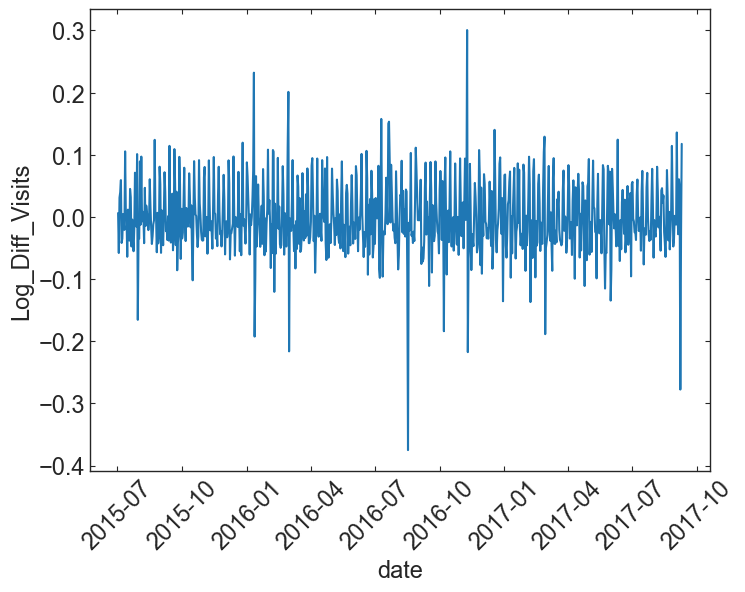

In [17]:
fig, ax = plt.subplots()

sns.lineplot(y=ts_log_diff.Log_Diff_Visits, x=ts_log_diff.index, ax=ax)
ax.tick_params(axis='x', rotation=45);

In [18]:
# drop NaN values due to the differencing
ts_log_diff.dropna(inplace=True)

# print out the ADF summary
report_stationarity(ts_log_diff.Log_Diff_Visits)

test statistics: -5.565137059519065
p-value: 1.510727880615172e-06
critical values: {'1%': -3.4387614757350087, '5%': -2.865252556432172, '10%': -2.5687469247205788}
----------------------------------------------------------------------------------------------------
The series is likely stationary!!


## Split into train and test for validation

In [19]:
def split_TS(data, period=60):
    ''' split dataset into train and test sets for validation
        period: size of the test sets (index from the end of the data)
    '''
    train_TS = data.iloc[:-period]
    test_TS  = data.iloc[-period:]
    
    print('train size: {:d} / test size: {:d}'.format(len(train_TS), len(test_TS)))
    return train_TS, test_TS

## Validation: Symmetric mean absolute percentage error (SMAPE or sMAPE)

In [20]:
def smape(y_true, y_pred):
    ''' calculate SMAPE function for validation '''
    if(len(y_true) != len(y_pred)):
        raise ValueError('y_true should be the same size with y_pred')
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.nanmean(diff)

# Modeling
- SARIMA
- Prophet
- LSTM

## SARIMA Modeling

### Auto-correlation function (ACF) and Partial auto-correlation function (PACF)

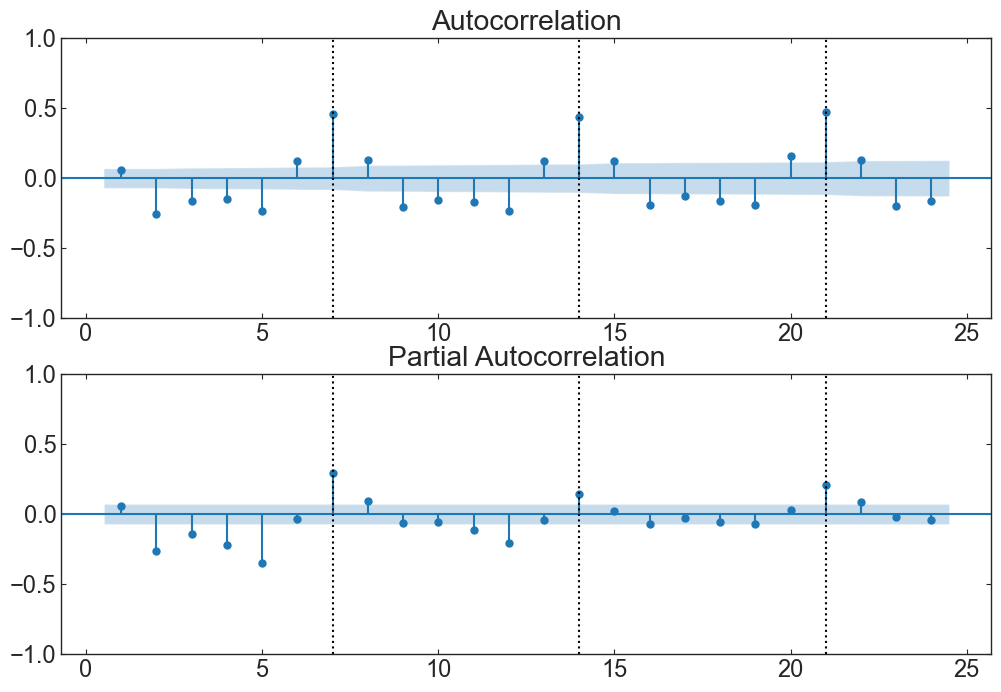

In [21]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))

# Plot ACF
plot_acf(ts_log_diff.Log_Diff_Visits, lags=24, zero=False, ax=ax1)
ax1.axvline(x=7, linestyle=':', color='black')
ax1.axvline(x=14, linestyle=':', color='black')
ax1.axvline(x=21, linestyle=':', color='black')

# Plot PACF
plot_pacf(ts_log_diff.Log_Diff_Visits, lags=24, zero=False, ax=ax2, method='ywm')
ax2.axvline(x=7, linestyle=':', color='black')
ax2.axvline(x=14, linestyle=':', color='black')
ax2.axvline(x=21, linestyle=':', color='black');

> In ACF and PACF, we could observe high correlation for 7 days lag.
> There is weekly seasonality in data.

In [22]:
''' split Time series into train and test'''
test_size = 60
train_ts, test_ts = split_TS(ts_log_diff, period=test_size)

train size: 742 / test size: 60


In [23]:
# Create auto_arima model
# Find best sarima model by evaluating AIC values
model_sarima = pm.auto_arima(train_ts['Log_Diff_Visits'], seasonal=True, m=7, d=0, D=1, \
                      max_p=2, max_q=2, \
                      trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[7] intercept   : AIC=inf, Time=2.61 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=-2038.470, Time=0.08 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=-2241.878, Time=0.92 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=-2040.470, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=-2048.108, Time=0.08 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=-2352.981, Time=1.19 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=1.83 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(0,0,0)(2,1,0)[7] intercept   : AIC=-2338.312, Time=0.80 sec
 ARIMA(2,0,0)(2,1,0)[7] intercept   : AIC=-2358.011, Time=0.92 sec
 ARIMA(2,0,0)(1,1,0)[7] intercept   : AIC=-2243.614, Time=0.48 sec
 ARIMA(2,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=1.99 sec
 ARIMA(2,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=1.52 sec
 ARIMA(2,0,1)(2,1,0)[7] intercept   : AIC=-2358.145, Ti

In [24]:
# Print model summary
print(model_sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  742
Model:             SARIMAX(2, 0, 2)x(2, 1, [], 7)   Log Likelihood                1188.045
Date:                            Wed, 11 Jan 2023   AIC                          -2360.091
Time:                                    15:53:28   BIC                          -2323.292
Sample:                                         0   HQIC                         -2345.898
                                            - 742                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -1.85e-05      0.000     -0.089      0.929      -0.000       0.000
ar.L1          0.1104      0.377   

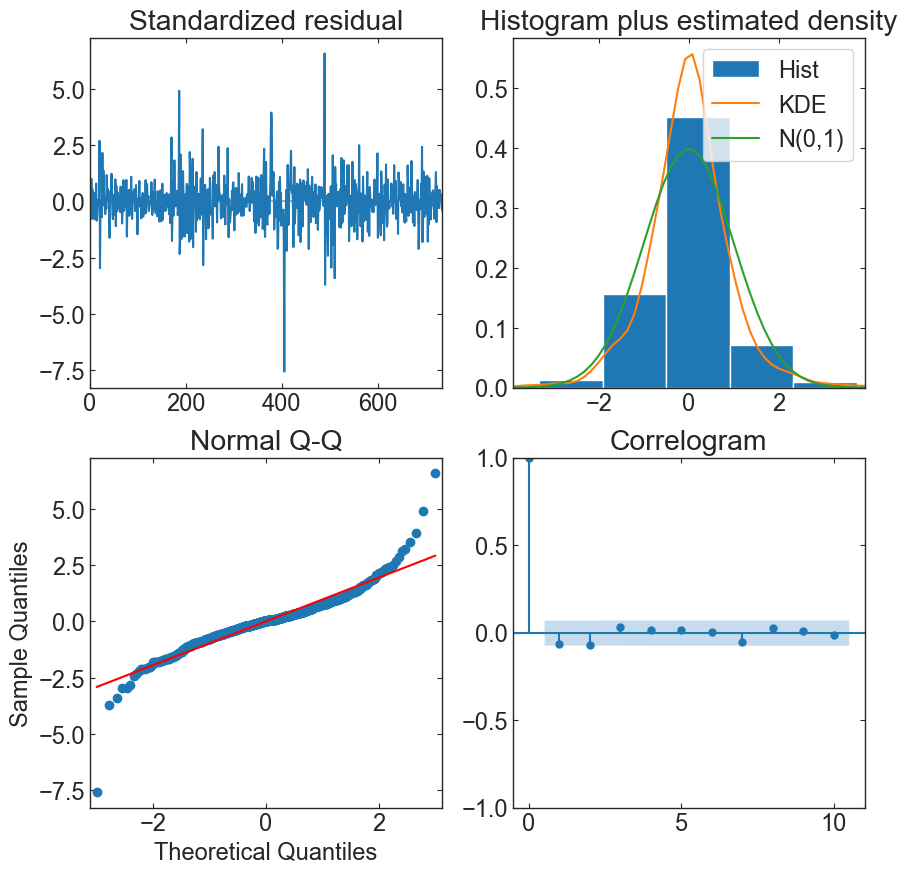

In [25]:
model_sarima.plot_diagnostics(figsize=(10,10));

In [26]:
# Forecast
n_periods = test_size #60
sarima_forecast, sarima_confint = model_sarima.predict(n_periods=n_periods, return_conf_int=True)

In [27]:
''' combine the last data point to forecast results '''

date_forecast = pd.date_range(start=train_ts.index[-1], periods=n_periods+1, freq='D') # to include the last date of the original dataset: n_periods+1

last_point = train_ts.Log_Diff_Visits[-1]
sarima_forecast = np.append(last_point, sarima_forecast)

sarima_confint = np.append([[last_point,last_point]], sarima_confint, axis=0)

In [28]:
''' Convert that range into a dataframe that includes predictions'''

df_sarima_forecast = pd.DataFrame(np.column_stack([sarima_forecast, sarima_confint[:,0], sarima_confint[:,1]]), \
                                  columns=['Prediction', 'Low_Conf', 'High_Conf'], index=date_forecast)
df_sarima_forecast.index.set_names('date', inplace=True)

df_sarima_forecast

,Prediction,Low_Conf,High_Conf
date,,,
2017-07-12,-0.016175,-0.016175,-0.016175
2017-07-13,-0.017314,-0.113841,0.079212
2017-07-14,-0.056062,-0.153243,0.041119
2017-07-15,0.035527,-0.061707,0.132762
2017-07-16,0.053784,-0.043753,0.151320
...,...,...,...
2017-09-06,-0.012526,-0.166629,0.141578
2017-09-07,-0.010650,-0.171302,0.150002
2017-09-08,-0.057274,-0.218094,0.103547


In [29]:
df_sarima_forecast.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 61 entries, 2017-07-12 to 2017-09-10
Freq: D
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Prediction  61 non-null     float64
 1   Low_Conf    61 non-null     float64
 2   High_Conf   61 non-null     float64
dtypes: float64(3)
memory usage: 1.9 KB


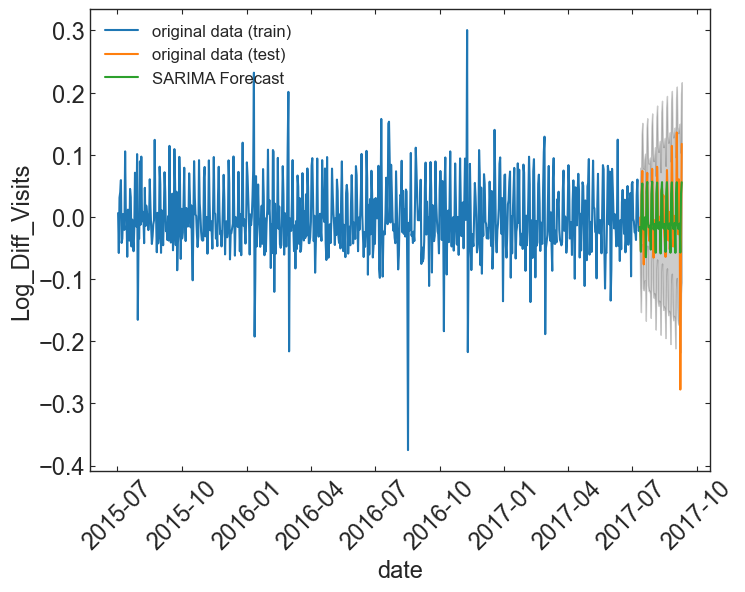

In [30]:
''' Plottiing the prediction along with the original dataset '''
fig, ax = plt.subplots()

sns.lineplot(y=train_ts.Log_Diff_Visits, x=train_ts.index, label='original data (train)', ax=ax)
sns.lineplot(y=test_ts.Log_Diff_Visits, x=test_ts.index, label='original data (test)', ax=ax)
sns.lineplot(y=df_sarima_forecast.Prediction, x=df_sarima_forecast.index, label='SARIMA Forecast', ax=ax)
ax.fill_between(df_sarima_forecast.index, df_sarima_forecast.Low_Conf, df_sarima_forecast.High_Conf, \
               alpha=0.2, color='k')
ax.tick_params(axis='x', rotation=45)
ax.legend(loc='upper left', fontsize=12, frameon=False);

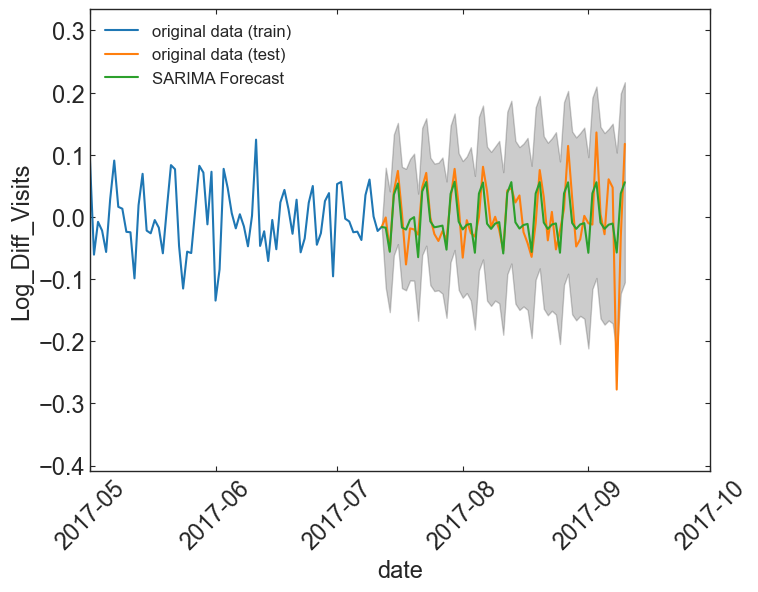

In [31]:
''' Zoomed-in plotting'''
fig, ax = plt.subplots()

# just for plotting purpose: add the last data point of the train to the test data
test_tmp = np.append(train_ts.Log_Diff_Visits[-1], test_ts.Log_Diff_Visits)
test_index_tmp = np.append(np.datetime64(train_ts.index[-1]), test_ts.index)

sns.lineplot(y=train_ts.Log_Diff_Visits, x=train_ts.index, label='original data (train)', ax=ax)
sns.lineplot(y=test_tmp, x=test_index_tmp, label='original data (test)', ax=ax)
sns.lineplot(y=df_sarima_forecast.Prediction, x=df_sarima_forecast.index, label='SARIMA Forecast', ax=ax)
ax.fill_between(df_sarima_forecast.index, df_sarima_forecast.Low_Conf, df_sarima_forecast.High_Conf, \
               alpha=0.2, color='k')

ax.set_xlim([pd.to_datetime('2017-05'),pd.to_datetime('2017-10')])
ax.tick_params(axis='x', rotation=45)
ax.legend(loc='upper left', fontsize=12, frameon=False);

In [32]:
''' rebuild the actual prediction from logarithmic and differenced prediction '''

pred_tmp = df_sarima_forecast.Prediction.copy()
pred_tmp[0] = 0   # the first element of the prediction should be zero, and will be calibrated by the last Visits of original data

df_sarima_forecast['Prediction_Actual'] = np.exp(pred_tmp.cumsum())*mean_timeSeries.Visits[len(train_ts)]

In [33]:
df_sarima_forecast

,Prediction,Low_Conf,High_Conf,Prediction_Actual
date,,,,
2017-07-12,-0.016175,-0.016175,-0.016175,1000.040065
2017-07-13,-0.017314,-0.113841,0.079212,982.874363
2017-07-14,-0.056062,-0.153243,0.041119,929.288526
2017-07-15,0.035527,-0.061707,0.132762,962.897195
2017-07-16,0.053784,-0.043753,0.151320,1016.103614
...,...,...,...,...
2017-09-06,-0.012526,-0.166629,0.141578,886.586749
2017-09-07,-0.010650,-0.171302,0.150002,877.194998
2017-09-08,-0.057274,-0.218094,0.103547,828.366472


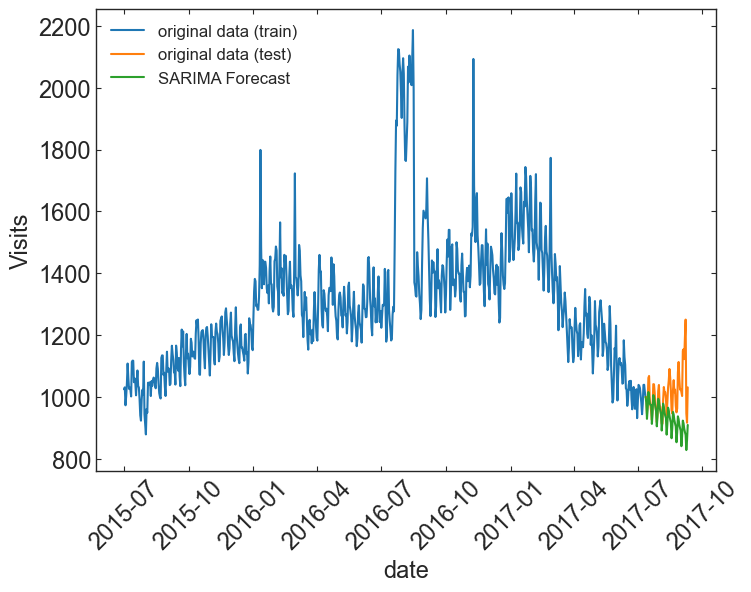

In [34]:
''' Plottiing the prediction along with the original dataset '''
fig, ax = plt.subplots()

sns.lineplot(y=mean_timeSeries[:-len(test_ts)].Visits, x=mean_timeSeries[:-len(test_ts)].index, label='original data (train)', ax=ax)
sns.lineplot(y=mean_timeSeries[-len(test_ts)-1:].Visits, x=mean_timeSeries[-len(test_ts)-1:].index, label='original data (test)', ax=ax)
sns.lineplot(y=df_sarima_forecast.Prediction_Actual, x=df_sarima_forecast.index, label='SARIMA Forecast', ax=ax)

ax.tick_params(axis='x', rotation=45)
ax.legend(loc='upper left', fontsize=12, frameon=False);

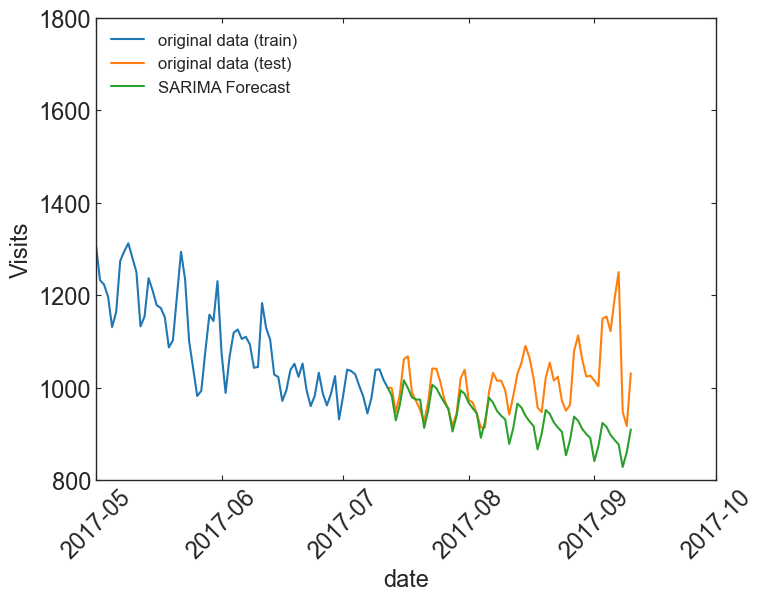

In [35]:
''' Zoomed-in plotting '''
fig, ax = plt.subplots()

#sns.lineplot(y=mean_timeSeries.Visits, x=mean_timeSeries.index, label='original data', ax=ax)
sns.lineplot(y=mean_timeSeries[:-len(test_ts)].Visits, x=mean_timeSeries[:-len(test_ts)].index, label='original data (train)', ax=ax)
sns.lineplot(y=mean_timeSeries[-len(test_ts)-1:].Visits, x=mean_timeSeries[-len(test_ts)-1:].index, label='original data (test)', ax=ax)
sns.lineplot(y=df_sarima_forecast.Prediction_Actual, x=df_sarima_forecast.index, label='SARIMA Forecast', ax=ax)

ax.set_xlim([pd.to_datetime('2017-05'),pd.to_datetime('2017-10')])
ax.set_ylim(800,1800)
ax.tick_params(axis='x', rotation=45)
ax.legend(loc='upper left', fontsize=12, frameon=False);

In [36]:
''' report SMAPE score '''

smape_sarima = smape(mean_timeSeries[-len(test_ts)-1:].Visits, df_sarima_forecast.Prediction_Actual)

print('SMAPE score: {:f}'.format(smape_sarima))

SMAPE score: 8.197610


## Prophet Modeling

In [37]:
df_prophet = mean_timeSeries[['Visits']].copy()

df_prophet.reset_index(drop=False,inplace=True)
df_prophet.columns = ['ds', 'y']

In [38]:
df_prophet

,ds,y
0,2015-07-01,1024.882127
1,2015-07-02,1031.251727
2,2015-07-03,973.138768
3,2015-07-04,1003.810839
4,2015-07-05,1044.361908
...,...,...
798,2017-09-06,1192.459890
799,2017-09-07,1250.224337
800,2017-09-08,947.043023
801,2017-09-09,916.763558


In [39]:
''' split Time series into train and test'''
test_size = 60
train_pro, test_pro = split_TS(df_prophet, period=test_size)

train size: 743 / test size: 60


In [40]:
train_pro

,ds,y
0,2015-07-01,1024.882127
1,2015-07-02,1031.251727
2,2015-07-03,973.138768
3,2015-07-04,1003.810839
4,2015-07-05,1044.361908
...,...,...
738,2017-07-08,978.190941
739,2017-07-09,1038.855844
740,2017-07-10,1039.577198
741,2017-07-11,1016.346950


In [41]:
model_pro = Prophet()

model_pro.fit(train_pro)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -12.2945
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1856.87   0.000298685       77.4839      0.2624      0.2624      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1861.06     0.0141134       162.649           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     236       1862.22   9.97918e-05       98.8659    1.19e-06       0.001      318  LS failed, Hessian reset 
     299       1862.44   0.000645745       89.3844           1           1      393   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     324       1863.48    0.00325999        227.82   2.163e-05       0.001      459  LS failed, Hessian reset 
     399       1864.27   0.000631843       78.0443      0.3347           1      552   
    Iter      log pro

In [42]:
date_future = model_pro.make_future_dataframe(periods=test_size, freq='D')

prophet_forecast = model_pro.predict(date_future)

In [43]:
prophet_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-07-01,979.568165,684.576830,963.876320,979.568165,979.568165,-151.674590,-151.674590,-151.674590,6.064817,6.064817,6.064817,-157.739408,-157.739408,-157.739408,0.0,0.0,0.0,827.893574
1,2015-07-02,980.626134,666.767373,927.138554,980.626134,980.626134,-185.936114,-185.936114,-185.936114,-27.432772,-27.432772,-27.432772,-158.503342,-158.503342,-158.503342,0.0,0.0,0.0,794.690020
2,2015-07-03,981.684103,625.014411,893.219468,981.684103,981.684103,-227.079785,-227.079785,-227.079785,-68.645054,-68.645054,-68.645054,-158.434731,-158.434731,-158.434731,0.0,0.0,0.0,754.604318
3,2015-07-04,982.742071,640.668540,909.123294,982.742071,982.742071,-212.499437,-212.499437,-212.499437,-55.138295,-55.138295,-55.138295,-157.361142,-157.361142,-157.361142,0.0,0.0,0.0,770.242634
4,2015-07-05,983.800040,735.679875,1012.662202,983.800040,983.800040,-109.116244,-109.116244,-109.116244,46.003700,46.003700,46.003700,-155.119945,-155.119945,-155.119945,0.0,0.0,0.0,874.683796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798,2017-09-06,1104.137124,948.320126,1215.977839,1096.849340,1111.260390,-15.476359,-15.476359,-15.476359,6.064817,6.064817,6.064817,-21.541176,-21.541176,-21.541176,0.0,0.0,0.0,1088.660766
799,2017-09-07,1102.825065,926.539582,1194.414751,1095.350181,1110.279571,-48.485492,-48.485492,-48.485492,-27.432772,-27.432772,-27.432772,-21.052721,-21.052721,-21.052721,0.0,0.0,0.0,1054.339572
800,2017-09-08,1101.513005,887.750759,1140.341960,1093.862005,1109.157927,-89.277492,-89.277492,-89.277492,-68.645054,-68.645054,-68.645054,-20.632438,-20.632438,-20.632438,0.0,0.0,0.0,1012.235513
801,2017-09-09,1100.200946,896.168230,1154.800426,1092.326650,1108.007201,-75.481142,-75.481142,-75.481142,-55.138295,-55.138295,-55.138295,-20.342847,-20.342847,-20.342847,0.0,0.0,0.0,1024.719804


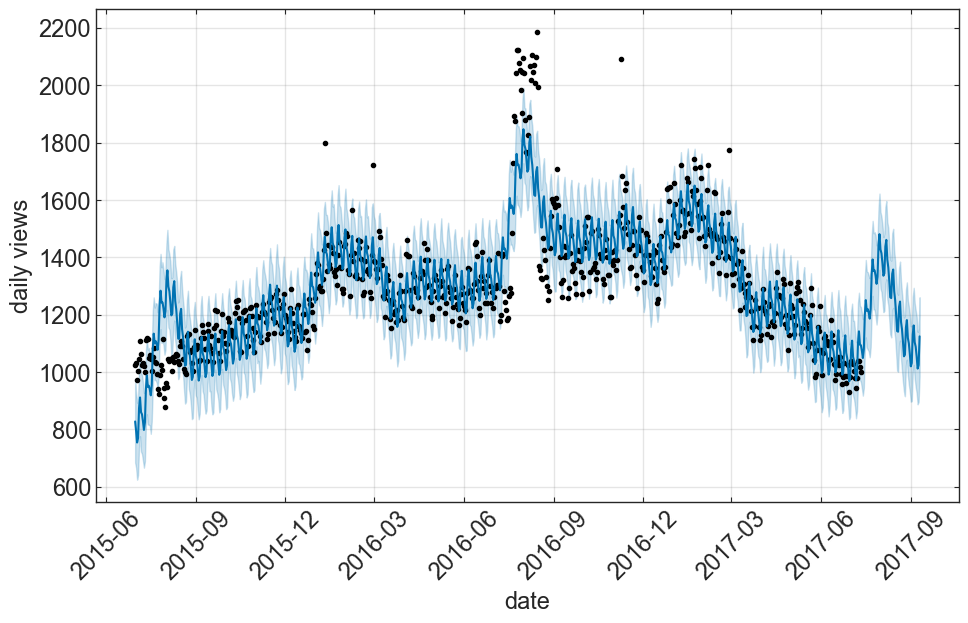

In [44]:
fig = model_pro.plot(prophet_forecast, xlabel='date', ylabel='daily views')
ax = fig.gca()
ax.tick_params(axis='x', rotation=45);

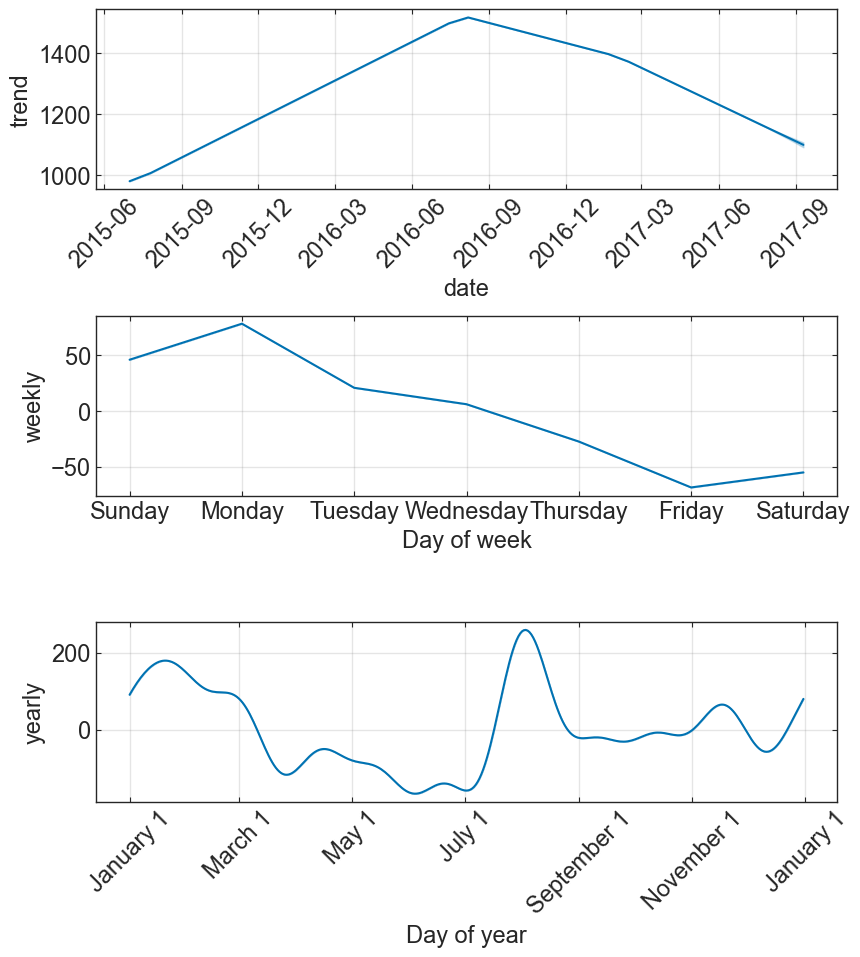

In [45]:
fig = model_pro.plot_components(prophet_forecast)
axes = fig.get_axes()
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_xlabel('date')
axes[2].tick_params(axis='x', rotation=45)
fig.subplots_adjust(hspace=0.7);

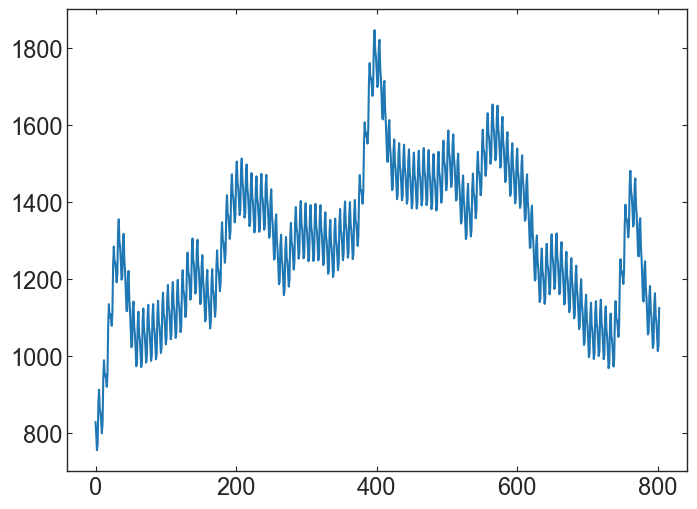

In [46]:
fig, ax = plt.subplots()
ax.plot(prophet_forecast.index, prophet_forecast.yhat)

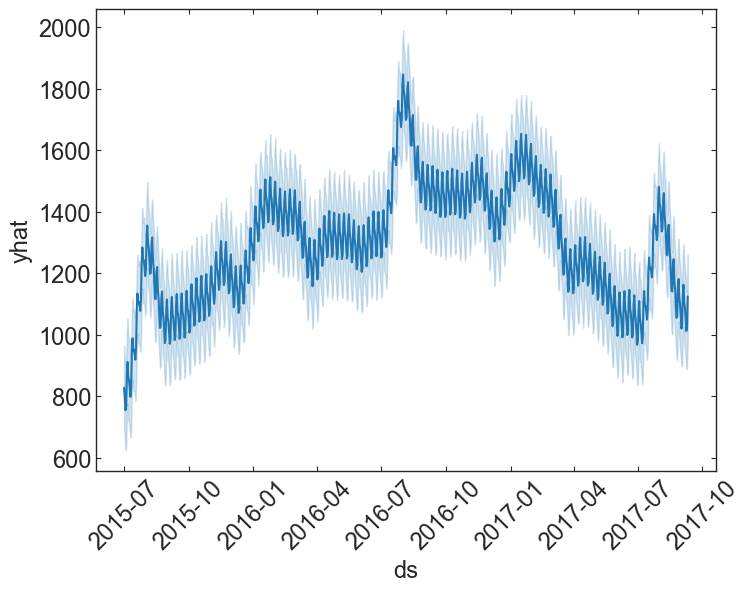

In [47]:
''' Plottiing the prediction along with the original dataset '''
fig, ax = plt.subplots()

sns.lineplot(y=prophet_forecast.yhat, x=prophet_forecast.ds, ax=ax)
ax.fill_between(prophet_forecast.ds, prophet_forecast.yhat_lower, prophet_forecast.yhat_upper, \
               alpha=0.2, color='C0')
ax.tick_params(axis='x', rotation=45);

In [48]:
df_prophet_forecast = prophet_forecast[['ds','yhat','yhat_lower','yhat_upper']].iloc[-len(test_pro):]

In [49]:
df_prophet_forecast.head(1)

,ds,yhat,yhat_lower,yhat_upper
743,2017-07-13,1074.616973,943.19908,1207.489981


In [50]:
mean_timeSeries.iloc[-61]

weekday       2.000000
weekend       0.000000
year       2017.000000
month         7.000000
day          12.000000
Visits     1000.040065
Name: 2017-07-12 00:00:00, dtype: float64

In [51]:
mean_timeSeries.index[-61]

Timestamp('2017-07-12 00:00:00')

In [52]:
''' combine the last data point to forecast results '''

ind = -len(test_pro) - 1
lastVisit = mean_timeSeries.iloc[ind].Visits
dict_lastpoint = {'ds': pd.to_datetime(mean_timeSeries.index[ind]), \
                'yhat': [lastVisit], 'yhat_lower': [lastVisit], \
                'yhat_upper': [lastVisit]}
df_lastpoint = pd.DataFrame(dict_lastpoint)
df_prophet_forecast = df_lastpoint.append(df_prophet_forecast, ignore_index=True)

df_prophet_forecast.set_index('ds', inplace=True)
df_prophet_forecast.index.rename('date', inplace=True)

In [54]:
df_prophet_forecast.head()

,yhat,yhat_lower,yhat_upper
date,,,
2017-07-12,1000.040065,1000.040065,1000.040065
2017-07-13,1074.616973,943.199080,1207.489981
2017-07-14,1049.240019,917.875238,1184.963767
2017-07-15,1079.931126,945.104846,1206.006100
2017-07-16,1199.436339,1073.692495,1330.288285


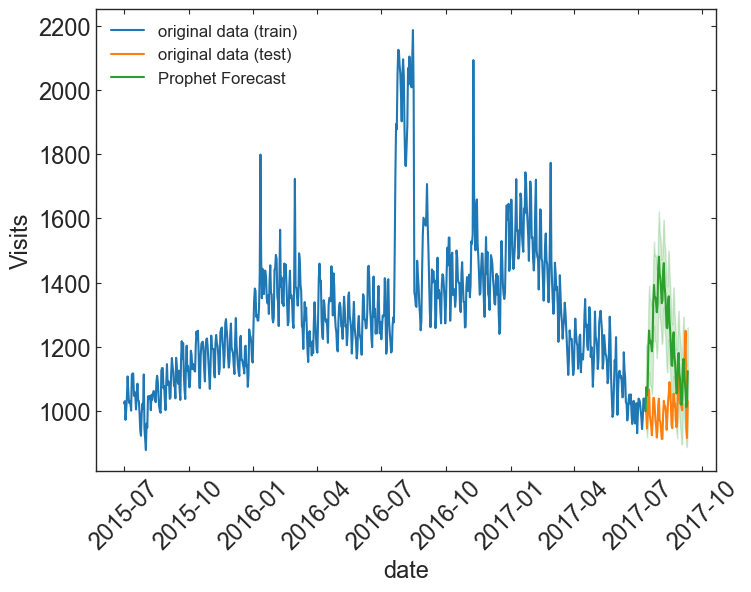

In [55]:
''' Plottiing the prediction along with the original dataset '''
fig, ax = plt.subplots()

sns.lineplot(y=mean_timeSeries[:-len(test_pro)].Visits, x=mean_timeSeries[:-len(test_pro)].index, label='original data (train)', ax=ax)
sns.lineplot(y=mean_timeSeries[-len(test_pro)-1:].Visits, x=mean_timeSeries[-len(test_pro)-1:].index, label='original data (test)', ax=ax)
sns.lineplot(y=df_prophet_forecast.yhat, x=df_prophet_forecast.index, label='Prophet Forecast', ax=ax)
ax.fill_between(df_prophet_forecast.index, df_prophet_forecast.yhat_lower, df_prophet_forecast.yhat_upper, \
               alpha=0.2, color='C2')

ax.tick_params(axis='x', rotation=45)
ax.legend(loc='upper left', fontsize=12, frameon=False);

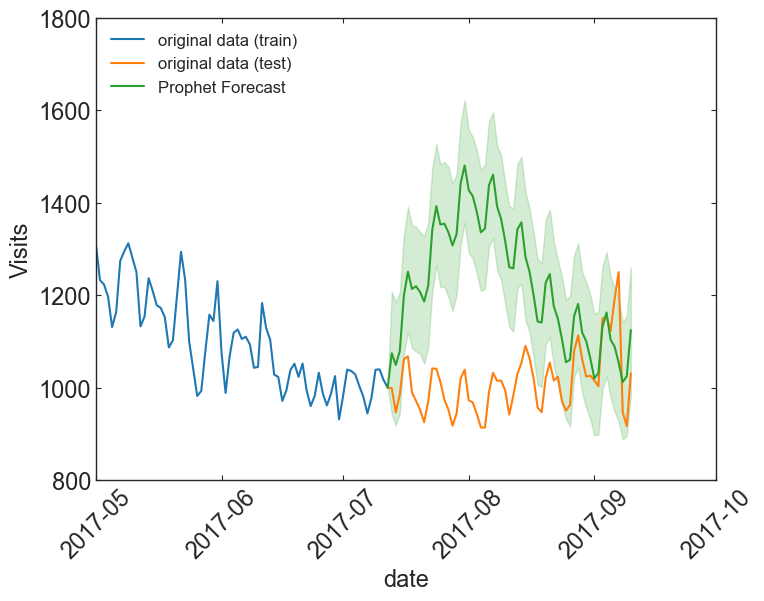

In [56]:
''' Zoomed-in plotting '''
fig, ax = plt.subplots()

sns.lineplot(y=mean_timeSeries[:-len(test_pro)].Visits, x=mean_timeSeries[:-len(test_pro)].index, label='original data (train)', ax=ax)
sns.lineplot(y=mean_timeSeries[-len(test_pro)-1:].Visits, x=mean_timeSeries[-len(test_pro)-1:].index, label='original data (test)', ax=ax)
sns.lineplot(y=df_prophet_forecast.yhat, x=df_prophet_forecast.index, label='Prophet Forecast', ax=ax)
ax.fill_between(df_prophet_forecast.index, df_prophet_forecast.yhat_lower, df_prophet_forecast.yhat_upper, \
               alpha=0.2, color='C2')

ax.set_xlim([pd.to_datetime('2017-05'),pd.to_datetime('2017-10')])
ax.set_ylim(800,1800)
ax.tick_params(axis='x', rotation=45)
ax.legend(loc='upper left', fontsize=12, frameon=False);

In [57]:
''' report SMAPE score '''

smape_prophet = smape(mean_timeSeries[-len(test_pro)-1:].Visits, df_prophet_forecast.yhat)

print('SMAPE score: {:f}'.format(smape_prophet))

SMAPE score: 19.313828


## Long Short-Term Memory (LSTM) Modeling

In [104]:
def split_sequence(sequence, look_back=1):
    X, Y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + look_back
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        Y.append(seq_y)
    return np.array(X),np.array(Y)

In [105]:
def build_LSTM(n_layer=2, layer_units=10, look_back=1):
    model = Sequential()
    model.add(LSTM(layer_units, activation='relu', input_shape=(look_back, 1), return_sequences=True))
    for layer in range(n_layer):
        model.add(LSTM(layer_units, activation='relu', return_sequences=True))
    model.add(LSTM(layer_units, activation='relu'))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mse')
    
    return model    

In [138]:
''' split Time series into train and test'''
df_lstm = mean_timeSeries[['Visits']].copy()

look_back = 10

test_size = 60 + look_back
train_lstm, test_lstm = split_TS(df_lstm, period=test_size)

train size: 733 / test size: 70


In [140]:
''' transform Time Series dataset into a supervised problem dataset '''

train_X, train_y = split_sequence(train_lstm.Visits, look_back=look_back)
test_X, test_y   = split_sequence(test_lstm.Visits, look_back=look_back)

In [141]:
''' reshape the data structure '''

train_X1 = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
test_X1  = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))

In [142]:
lstm_model = build_LSTM(n_layer=4, layer_units=50, look_back=look_back)

In [143]:
lstm_model.fit(train_X1, train_y, epochs=100, verbose=1)

Epoch 1/100
23/23 [==============================] - 6s 15ms/step - loss: 1509634.1250
Epoch 2/100
23/23 [==============================] - 0s 14ms/step - loss: 42111.5586
Epoch 3/100
23/23 [==============================] - 0s 14ms/step - loss: 22200.6836
Epoch 4/100
23/23 [==============================] - 0s 14ms/step - loss: 19722.9453
Epoch 5/100
23/23 [==============================] - 0s 14ms/step - loss: 19681.5898
Epoch 6/100
23/23 [==============================] - 0s 14ms/step - loss: 20708.2578
Epoch 7/100
23/23 [==============================] - 0s 14ms/step - loss: 22246.5879
Epoch 8/100
23/23 [==============================] - 0s 14ms/step - loss: 27753.3496
Epoch 9/100
23/23 [==============================] - 0s 14ms/step - loss: 20520.2949
Epoch 10/100
23/23 [==============================] - 0s 14ms/step - loss: 16023.2900
Epoch 11/100
23/23 [==============================] - 0s 14ms/step - loss: 17482.5820
Epoch 12/100
23/23 [==============================] - 0s 14ms

In [144]:
lstm_forecast = lstm_model.predict(test_X1)

2/2 [==============================] - 1s 6ms/step


In [160]:
df_lstm_forecast = pd.DataFrame(lstm_forecast, columns=['Prediction'], index=mean_timeSeries[-len(lstm_forecast):].index)
df_lstm_forecast.head()

,Prediction
date,
2017-07-13,967.002563
2017-07-14,960.733521
2017-07-15,962.746094
2017-07-16,967.988464
2017-07-17,967.919922


In [161]:
''' combine the last data point to forecast results '''

ind = -len(df_lstm_forecast) - 1
lastVisit = mean_timeSeries.iloc[ind].Visits

df_lastpoint = pd.DataFrame([lastVisit], columns=['Prediction'], index=[pd.to_datetime(mean_timeSeries.index[ind])])

df_lstm_forecast = df_lastpoint.append(df_lstm_forecast, ignore_index=False)

df_lstm_forecast.head()

,Prediction
2017-07-12,1000.040065
2017-07-13,967.002563
2017-07-14,960.733521
2017-07-15,962.746094
2017-07-16,967.988464


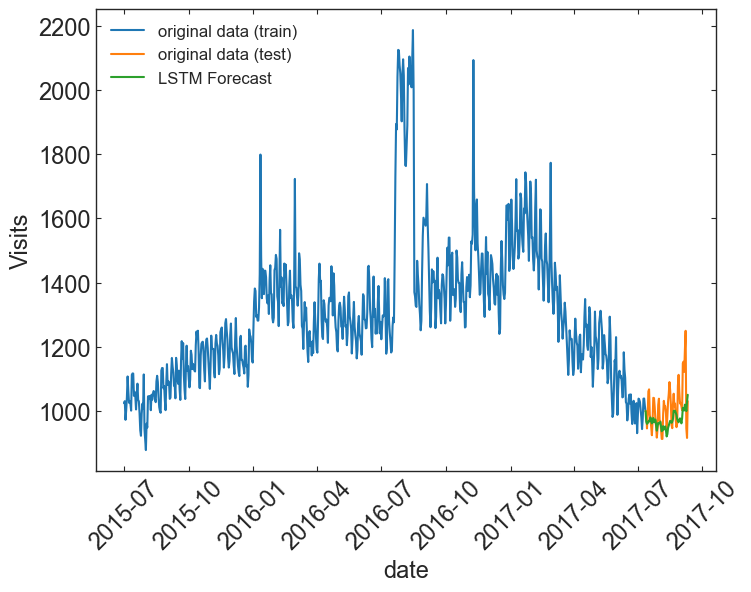

In [162]:
''' Plottiing the prediction along with the original dataset '''
fig, ax = plt.subplots()

sns.lineplot(y=mean_timeSeries[:-len(test_pro)].Visits, x=mean_timeSeries[:-len(test_pro)].index, label='original data (train)', ax=ax)
sns.lineplot(y=mean_timeSeries[-len(test_pro)-1:].Visits, x=mean_timeSeries[-len(test_pro)-1:].index, label='original data (test)', ax=ax)
sns.lineplot(y=df_lstm_forecast.Prediction, x=df_lstm_forecast.index, label='LSTM Forecast', ax=ax)

ax.tick_params(axis='x', rotation=45)
ax.legend(loc='upper left', fontsize=12, frameon=False);

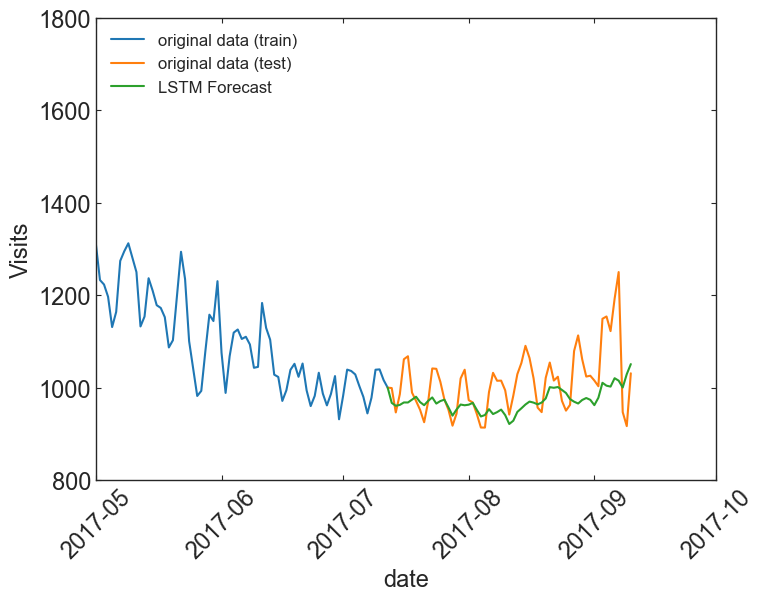

In [163]:
''' Zoomed-in plotting '''

fig, ax = plt.subplots()

sns.lineplot(y=mean_timeSeries[:-len(test_pro)].Visits, x=mean_timeSeries[:-len(test_pro)].index, label='original data (train)', ax=ax)
sns.lineplot(y=mean_timeSeries[-len(test_pro)-1:].Visits, x=mean_timeSeries[-len(test_pro)-1:].index, label='original data (test)', ax=ax)
sns.lineplot(y=df_lstm_forecast.Prediction, x=df_lstm_forecast.index, label='LSTM Forecast', ax=ax)

ax.set_xlim([pd.to_datetime('2017-05'),pd.to_datetime('2017-10')])
ax.set_ylim(800,1800)

ax.tick_params(axis='x', rotation=45)
ax.legend(loc='upper left', fontsize=12, frameon=False);

In [166]:
''' report SMAPE score '''

smape_lstm = smape(mean_timeSeries[-len(df_lstm_forecast):].Visits, df_lstm_forecast.Prediction)

print('SMAPE score: {:f}'.format(smape_lstm))

SMAPE score: 5.412687


## Compare the results from the 3 models.

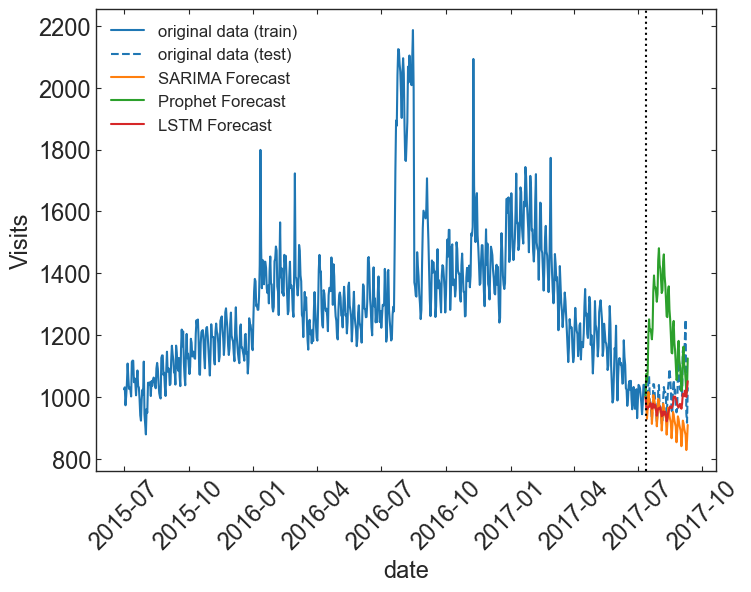

In [209]:
''' Plottiing the prediction along with the original dataset '''
fig, ax = plt.subplots()

lw=1.5
sns.lineplot(y=mean_timeSeries[:-len(test_pro)].Visits, x=mean_timeSeries[:-len(test_pro)].index, \
             label='original data (train)', color='C0', lw=lw, ax=ax)
sns.lineplot(y=mean_timeSeries[-len(test_pro)-1:].Visits, x=mean_timeSeries[-len(test_pro)-1:].index, \
             label='original data (test)', color='C0', lw=lw, linestyle='--', ax=ax)
sns.lineplot(y=df_sarima_forecast.Prediction_Actual, x=df_sarima_forecast.index, label='SARIMA Forecast', \
             color='C1', lw=lw, ax=ax)
sns.lineplot(y=df_prophet_forecast.yhat, x=df_prophet_forecast.index, label='Prophet Forecast', \
             color='C2', lw=lw, ax=ax)
sns.lineplot(y=df_lstm_forecast.Prediction, x=df_lstm_forecast.index, label='LSTM Forecast', \
             color='C3', lw=lw, ax=ax)

ax.axvline(x=pd.to_datetime(mean_timeSeries.index[-len(test_pro)-1]), linestyle=':', color='k')

ax.tick_params(axis='x', rotation=45)
ax.legend(loc='upper left', fontsize=12, frameon=False);

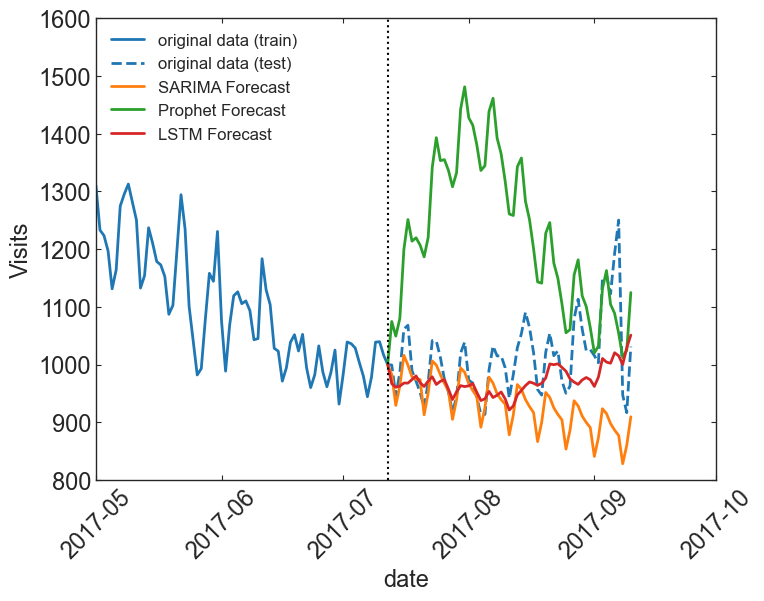

In [214]:
''' Zoomed-in plotting '''
fig, ax = plt.subplots()

lw=2
sns.lineplot(y=mean_timeSeries[:-len(test_pro)].Visits, x=mean_timeSeries[:-len(test_pro)].index, \
             label='original data (train)', color='C0', lw=lw, ax=ax)
sns.lineplot(y=mean_timeSeries[-len(test_pro)-1:].Visits, x=mean_timeSeries[-len(test_pro)-1:].index, \
             label='original data (test)', color='C0', lw=lw, linestyle='--', ax=ax)
sns.lineplot(y=df_sarima_forecast.Prediction_Actual, x=df_sarima_forecast.index, label='SARIMA Forecast', \
             color='C1', lw=lw, ax=ax)
sns.lineplot(y=df_prophet_forecast.yhat, x=df_prophet_forecast.index, label='Prophet Forecast', \
             color='C2', lw=lw, ax=ax)
sns.lineplot(y=df_lstm_forecast.Prediction, x=df_lstm_forecast.index, label='LSTM Forecast', \
             color='C3', lw=lw, ax=ax)

ax.axvline(x=pd.to_datetime(mean_timeSeries.index[-len(test_pro)-1]), linestyle=':', color='k')

ax.set_xlim([pd.to_datetime('2017-05'),pd.to_datetime('2017-10')])
ax.set_ylim(800,1600)

ax.tick_params(axis='x', rotation=45)
ax.legend(loc='upper left', fontsize=12, frameon=False);

In [175]:
dict_smape = {'SARIMA':[smape_sarima], 'Prophet':[smape_prophet], 'LSTM':[smape_lstm]}

df_smape = pd.DataFrame(dict_smape, index=['sMAPE'])

df_smape = df_smape.T
df_smape

,sMAPE
SARIMA,8.197610
Prophet,19.313828
LSTM,5.412687


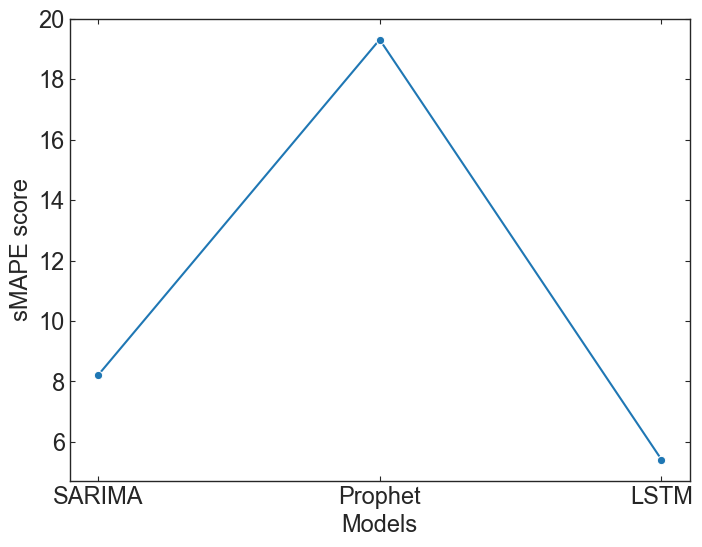

In [191]:
ax = sns.lineplot(data=df_smape, x=df_smape.index, y='sMAPE', marker='o', dashes=False)
ax.set(xlabel='Models', ylabel='sMAPE score');

# Conclusion